In [2]:
import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
#이 코드 파일이 존재하는 working directory에 mlp_img 폴더가 없으면, mlp_img 폴더 생성 
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [4]:
#input image 변환을 위한 함수
def to_img_latent(x):
    x = 0.5 * (x + 1)  
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 2, 2)
    return x

In [5]:
#output image 변환을 위한 함수
def to_img(x):
    x = 0.5 * (x + 1)  
    x = x.clamp(0, 1) 
    x = x.view(x.size(0), 1, 28, 28)
    return x

#### MNIST data 받아오기 

In [6]:
from torch.utils.data import DataLoader  
from torchvision.datasets import MNIST  

In [7]:
num_epochs = 100 #training data 전체(여기서는 6만개)를 딱 한 번 사용했을 때, 한 epoch이 지나갔다고 말함 
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([  #composes several transforms together  
    transforms.ToTensor(), #여기서는 PIL.Image.Image 를 tensor로 바꿔줌 
    transforms.Normalize((0.5,), (0.5,)) #channel 1이므로 각 1개의 element에 해당하는 mean / stdev 
])  


dataset = MNIST('./data', transform=img_transform, download  = True) #default 옵션은 train = True 
#Dataloader은 Iterator을 반환한다
#배치사이즈만큼 데이터를 로드해줌
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 

In [10]:
print(dataset)  

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None


In [18]:
class autoencoder(nn.Module):
    def __init__(self):
        """
        생성자에서 2개의 nn.Sequential 모듈을 생성하고, 멤버변수(self.encoder, self.decoder)로 지정한다.  
        """
        super(autoencoder, self).__init__() # 부모클래스(nn.Module)에서 정의된 메소드를 호출, 생성자 선언 
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True), #inplace = True 옵션 -> 또 다른 객체를 반환하지 않고 기존 객체를 수정, 메모리를 아주 조금 save 할 수 있다.    
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 4))
        self.decoder = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(True),  # ReLU를 쓰는 이유는 이게 generation이 아니라 classification이 목적이라서,, 데이터를 많이 버리는 게 좋음 
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh()) #마지막 layer에 tanh 안해주면 MSEloss 엄청 커짐.. 


    def forward(self, x):
        """
        순전파 함수에서는 입력 데이터의 Variable을 받아서 출력 데이터의 Variable을
        반환해야 합니다. Variable 상의 임의의 연산자뿐만 아니라 생성자에서 정의한
        모듈을 사용할 수 있습니다.
        """
        x_latent = self.encoder(x)
        x_output = self.decoder(x_latent)
        return x_latent, x_output 
    

In [19]:
model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

#### Training AE using training data of MNIST

In [20]:
for epoch in range(1):#num_epochs  
    for data in dataloader:
        inputs, label = data #inputs.shape = [128,1,28,28], label = [128]
        inputs = inputs.view(inputs.size(0), -1)  #view는 size변경. inputs.size(0) = 128. 즉 inputs의 size를 [128,784]로 바꿔줌 
        inputs = Variable(inputs) # model에 넣어주려면 Variable로 싸줘야함 
        # ===================forward=====================
        latent, output = model(inputs) #autoencoder내에서 forward 진행됨
        #print(latent.shape)
        #print(output.shape)
        loss = criterion(output, inputs) #MSEloss
        # ===================backward====================
        optimizer.zero_grad()  #무슨기능?
        loss.backward()  #무슨기능?
        optimizer.step() #무슨기능? 
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))
    # ===============Latent Space와, Output 의 결과값 그림으로 저장 ===============
    if epoch % 10 == 0: #10epoch 지날 때마다 latent space에서의 이미지랑, output의 이미지를 보여줌 
        # ----------latent의 이미지 보여주기 ------------
        #print(latent.shape) # 여기서 96개가 남는 이유는 마지막 interation에서 60000 - 128*n 하면 남는 나머지
        pic = to_img_latent(latent.data)  #to_img_latent 
        save_image(pic, './mlp_img/latent_{}.png'.format(epoch))  
        
        #-----------output의 이미지 보여주기 -------------
        #print(output.shape)
        pic = to_img(output.data) #to_img 
        save_image(pic, './mlp_img/output_{}.png'.format(epoch))  

torch.save(model.state_dict(), './sim_autoencoder.pth')  

epoch [1/100], loss:0.1925


#### Test using MNIST 
- 앞에서 training한 모델에 test input 넣고 forward propagation  
- show output & show latent space  

In [21]:
test_dataset = MNIST('./data', train = False, transform=img_transform, download  = True) #default 옵션은 train = True 
dataloader = DataLoader(test_dataset, batch_size = 10000, shuffle=True)  

In [22]:
print(test_dataset)  

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None


#### test data를 가지고, 앞에서 만들어진 AE에 forward 진행

In [35]:
import matplotlib.pyplot as plt
import numpy as np

In [24]:
for i in range(1): #test data에 대해서 한번만 실행 
    for data in dataloader: #batch_size = 10000 
        test_inputs, label = data
        test_inputs = test_inputs.view(test_inputs.size(0), -1)
        test_inputs = Variable(test_inputs)
        # ========= forward =========
        latent, output = model(test_inputs)
        print(latent)
        loss = criterion(output, test_inputs)
        print('test_loss(MSE) :{:.4f}'.format(loss.data))

tensor([[ 15.2192,  10.8331,  -0.7731,   3.1964],
        [ 14.6433,   9.4716,  -4.6333,   5.3152],
        [  6.1711,  -1.9942,  -2.2601,   5.3603],
        ...,
        [ 16.7176,  11.9605, -10.5355,   5.9129],
        [  9.8286,   2.8203,  -7.9297,   3.2212],
        [  8.5403,   2.6621,  -6.4132,   5.7935]], grad_fn=<AddmmBackward>)
test_loss(MSE) :0.1937


In [25]:
print(latent.shape)
print(label.shape) #원래 데이터에 대한 label
print(output.shape) #AE를 거친 output 
#print(output[10]) #10번째 데이터 어떻게 생겼는지
print(output[2000].shape)  

torch.Size([10000, 4])
torch.Size([10000])
torch.Size([10000, 784])
torch.Size([784])


In [29]:
#이 두개를 비교해서 matplotlib에 찍어줘야 함
print(test_inputs.shape)  
print(output.shape)  

torch.Size([10000, 784])
torch.Size([10000, 784])


#### matplotlib 이용해서 실제 데이터와 모델 output 데이터를 찍어주자!
- 정답(test_inputs)/output/정답(test_inputs)/output ....

In [81]:
temp = np.array(test_inputs[0]) #tensor를 array로 바꾸어줘야 matplotlib로 그릴 수 있음  
temp = np.reshape(temp, (28, 28)) # (784,)를 (28,28)로 만들어줌 

(10000, 784)

In [140]:
#tensor를 array로 바꾸어줘야 matplotlib로 그릴 수 있음  
# (784,)를 (28,28)로 만들어줌 
test_np = np.array(test_inputs) 
test_np.shape
output_np = output.detach().numpy()
output_np.shape

(10000, 784)

In [143]:
output_np[0].shape

(784,)

In [88]:
import scipy
from scipy.stats import norm

In [144]:
#------------이제 test_np랑 output_np를 쓰면 됩니다. ------------
n = 20 
digit_size = 28 #픽셀단위?
figure = np.zeros((digit_size*n, digit_size*n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [146]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):  
        if j % 2 == 0:
            test_tmp = np.array(test_np[int(j/2)])  
            test_tmp = np.reshape(test_tmp, (28, 28))  #실제 데이터
            figure[(i*digit_size):((i + 1) * digit_size), (j*digit_size): ((j+1)*digit_size)] = test_tmp
        else:
            out_tmp = np.array(output_np[int(j/2)]) 
            out_tmp = np.reshape(out_tmp, (28, 28)) #모델의 output 데이터 
            figure[(i*digit_size):((i + 1) * digit_size), (j*digit_size): ((j+1)*digit_size)] = out_tmp


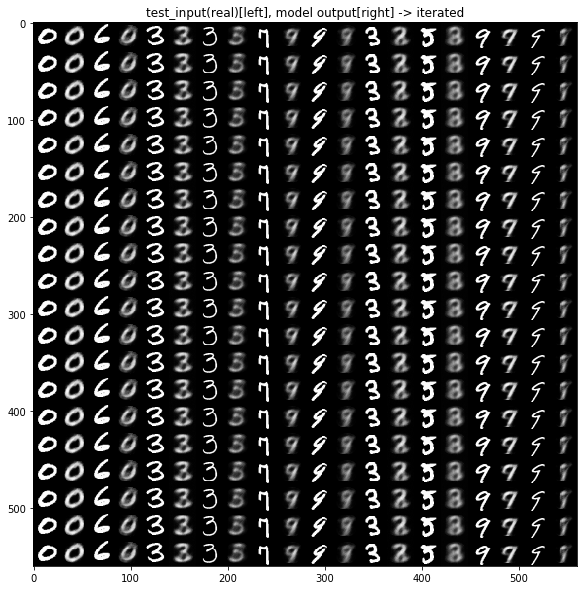

In [152]:
plt.figure(figsize = (10,10))
plt.title('test_input(real)[left], model output[right] -> iterated')
plt.imshow(figure, cmap = 'gray')  
plt.show() 

#### matplotlib 사용해서 latent space를 visualization 하자!

In [150]:
# test 데이터를 forward propagation 했을 때 latent space를 visualization 하자
print(latent.shape)


torch.Size([10000, 4])
